Load data

In [1]:
import os
import pandas as pd
import glob
from typing import Tuple, List

In [2]:
path_to_data_folder = os.path.join(os.getcwd(), "data")
print(os.path.join(path_to_data_folder, '*.txt'))
for f in glob.glob(os.path.join(path_to_data_folder, '*.txt')):
    variable_name = os.path.splitext(os.path.basename(f))[0]
    globals()[variable_name] = pd.read_csv(f, delimiter='\t')
    globals()[variable_name].columns = ['Time[s]','VGRF-left1', 'VGRF-left2','VGRF-left3','VGRF-left4','VGRF-left5','VGRF-left6','VGRF-left7','VGRF-left8','VGRF-right1', 'VGRF-right2','VGRF-right3','VGRF-right4','VGRF-right5','VGRF-right6','VGRF-right7','VGRF-right8','Total Force-left','Total Force-right']

E:\PD_gait_analysis\data\*.txt


In [3]:
def divide_dataset_to_Co_and_Pt(path_to_data_folder: str) -> Tuple[List[str], List[str]]:
    """

    Parameters
    ----------
    path_to_data_folder: str
        path to data folder

    Returns
    -------
    file_names_Co: List[str]
        list contains names of files containing Co in name
    file_names_Pt: List[str]
        list contains names of files containing Pt in name
    """

    file_names = os.listdir(path_to_data_folder)
    file_names_Co = [i for i in file_names if 'Co' in i]
    file_names_Pt = [i for i in file_names if 'Pt' in i]
    return file_names_Co, file_names_Pt

In [4]:
file_names_Co, file_names_Pt = divide_dataset_to_Co_and_Pt(path_to_data_folder)

Gait Phase Detection


In [5]:
import scipy.signal
import matplotlib.pyplot as plt

In [6]:
def remove_spikes(signal: pd.core.frame.DataFrame) -> List[float]:
    """
    Remove spikes within swing phase

    Parameters
    ----------
    signal: pd.core.frame.DataFrame
        data frame contains dynamic center od pressure during gait

    Returns
    -------
    signal_no_spikes: List[float]
        list contains coordinates of center of pressure for left foot"""
    signal_no_spikes = signal
    for index in range(1,len(signal)):
        if((signal.iloc[index-1]==0 and signal.iloc[index]>0 and signal.iloc[index+1]==0)\
                or (signal.iloc[index-1]==0 and signal.iloc[index]>0 and signal.iloc[index+1]>0) \
                or (signal.iloc[index-1]==0 and signal.iloc[index]<0 and signal.iloc[index+1]==0)):
            signal_no_spikes.iloc[index]=0
        else:
            pass
    return signal_no_spikes

In [7]:
def center_of_pressure_detection(file_name: pd.core.frame.DataFrame) -> Tuple[List[float], List[float]]:

    """
    Parameters
    ----------
    file_name: pd.core.frame.DataFrame
        data frame contains time[s], measurements from 16 pressure sensors - 8 left leg and 8 right leg, and total force for left leg and right leg

    Returns
    -------
    y_left: List[float]
        list contains coordinates of center of pressure for left foot
    y_right: List[float]
        list contains coordinates of center of pressure for right foot
    """

    # L1 (-500,-800) R1 (500,-800)
    # L2 (-700,-400) R2 (700,-400)
    # L3 (-300,-400) R3 (300,-400)
    # L4 (-700,0)    R4 (700,0)
    # L5 (-300,0)    R5 (300,0)
    # L6 (-700,400)  R6 (700,400)
    # L7 (-300,400)  R7 (300,400)
    # L8 (-500,800)  R8 (500,800)

    y_coordinates = {'1': -800,'2': -400,'3': -400,'4': 0,'5': 0,'6': 400,'7': 400,'8': 800}
    filename_col_names_left_leg = ['VGRF-left1', 'VGRF-left2','VGRF-left3','VGRF-left4','VGRF-left5','VGRF-left6','VGRF-left7','VGRF-left8']
    filename_col_names_right_leg = ['VGRF-right1', 'VGRF-right2','VGRF-right3','VGRF-right4','VGRF-right5','VGRF-right6','VGRF-right7','VGRF-right8']

    y_coordinates_left = sum(file_name[filename_col_names_left_leg[i]]*y_coordinates[str(i+1)] for i in range(len(filename_col_names_left_leg)))/file_name['Total Force-left']
    y_coordinates_right = sum(file_name[filename_col_names_right_leg[i]]*y_coordinates[str(i+1)] for i in range(len(filename_col_names_right_leg)))/file_name['Total Force-right']

    # file_name['Total Force-left'] can be 0 because during swing phase total pressure equals to 0
    # then all NaN values are replaced with 0
    y_coordinates_left = y_coordinates_left.fillna(0)
    y_coordinates_right = y_coordinates_right.fillna(0)

    y_coordinates_left = remove_spikes(y_coordinates_left)
    y_coordinates_right = remove_spikes(y_coordinates_right)

    # filtering signals with medianfilter
    # y_coordinates_left_filtered = scipy.signal.medfilt(y_coordinates_left,kernel_size=31)
    # y_coordinates_right_filtered = scipy.signal.medfilt(y_coordinates_right,kernel_size=31)
    y_coordinates_left_filtered = scipy.ndimage.uniform_filter1d(y_coordinates_left,size=15)
    y_coordinates_right_filtered = scipy.ndimage.uniform_filter1d(y_coordinates_right,size=15)
    # y_coordinates_left_filtered = y_coordinates_left
    # y_coordinates_right_filtered = y_coordinates_right
    return y_coordinates_left_filtered, y_coordinates_right_filtered

In [8]:
y_COP_left, y_COP_right = center_of_pressure_detection(GaCo01_01)

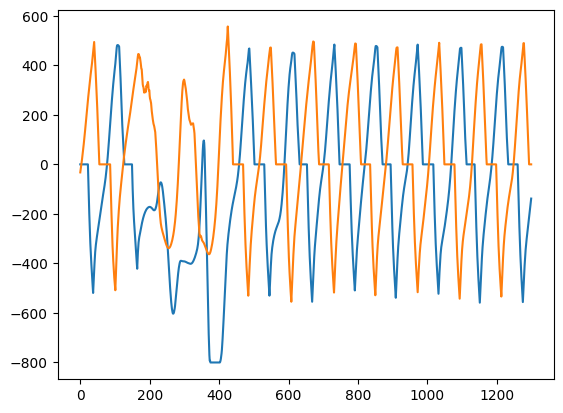

In [9]:
plt.plot(y_COP_left[2500:3800])
plt.plot(y_COP_right[2500:3800])

In [10]:
import numpy as np

In [11]:
def sensor_placement_detection_in_gait_phases(signal: np.ndarray):
    """
    Parameters
    ----------
    signal: np.ndarray
        contains CoP data
    Returns
    -------

    """
    max_values_signal, _ = scipy.signal.find_peaks(signal,threshold=0,distance=70)
    min_values_signal, _ = scipy.signal.find_peaks(-signal,threshold=0,distance=70)

    # remove too low values of max peaks
    max_values_signal = [max_peak for max_peak in max_values_signal if signal[max_peak] > 100 ]
    min_values_signal = [min_peak for min_peak in min_values_signal if signal[min_peak] < -100 ]

    return max_values_signal, min_values_signal

In [12]:
max_COP_left,min_COP_left = sensor_placement_detection_in_gait_phases(y_COP_left)

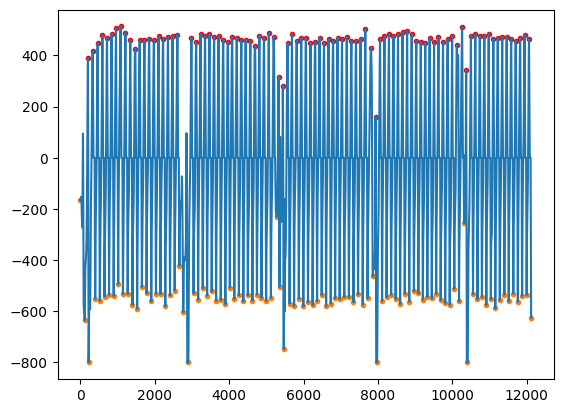

In [13]:
plt.scatter(max_COP_left,y_COP_left[max_COP_left], marker='.', edgecolors='red')
plt.scatter(min_COP_left,y_COP_left[min_COP_left], marker='.')
plt.plot(y_COP_left)

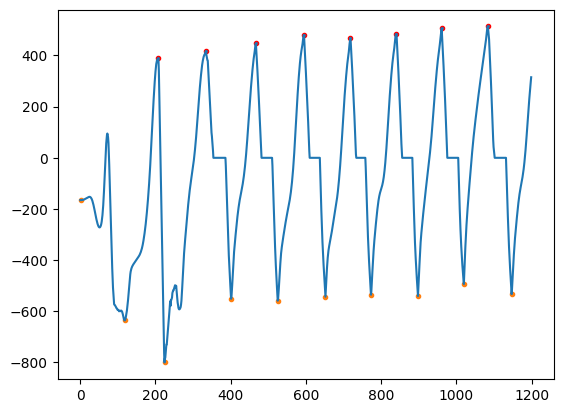

In [14]:
maximum_values = [i for i in max_COP_left if i<1200]
minimum_values = [i for i in min_COP_left if i<1200]
plt.scatter(maximum_values,y_COP_left[maximum_values], marker='.', edgecolors='red')
plt.scatter(minimum_values,y_COP_left[minimum_values], marker='.')
plt.plot(y_COP_left[0:1200])

In [15]:
def peaks_gait_mean_and_std_calc(peaks):
    return np.mean(peaks), np.std(peaks)

In [16]:
mean_max_peaks_left, std_max_peaks_left= peaks_gait_mean_and_std_calc(y_COP_left[max_COP_left])
mean_min_peaks_left, std_min_peaks_left = peaks_gait_mean_and_std_calc(y_COP_left[min_COP_left])

In [17]:
print(mean_max_peaks_left, std_max_peaks_left)
print(mean_min_peaks_left, std_min_peaks_left)

459.1796237455578 44.96107243696338
-550.4170558857941 84.06963016159419


In [18]:
print(max_COP_left[0])

207


In [19]:
def stance_swing_phase_detection(max_peaks_indices, min_peaks_indices):
    max_peaks_ind = max_peaks_indices
    min_peaks_ind = min_peaks_indices
    stance_duration = []
    swing_duration = []
    length_max_peaks_indices = len(max_peaks_ind)
    length_min_peaks_indices = len(min_peaks_ind)
    print('length_max_peaks_ind',length_max_peaks_indices)
    print('length_min_peaks_ind',length_min_peaks_indices)

    if length_min_peaks_indices > length_max_peaks_indices:
        length = length_max_peaks_indices
    else:
         length = length_min_peaks_indices

    print('max_peaks_ind',max_peaks_ind)
    print('min_peaks_ind',min_peaks_ind)
    print('min_peaks_indices',min_peaks_indices)

    # check what is first -> heel strike (minimum) or toe-off (maximum)
    if max_peaks_indices[0]>min_peaks_indices[0]:
        for i in range(1,length):
            stance_time = (max_peaks_ind[i-1] - min_peaks_ind[i-1])*0.01
            if stance_time<1.5:
                stance_duration.append(stance_time)
                # swing_duration.append((min_peaks_ind[i] - max_peaks_ind[i-1])*0.01)
            else:
                min_peaks_ind.pop(0)
    else:
        for i in range(1,length):
            stance_time = (max_peaks_ind[i] - min_peaks_ind[i-1])*0.01
            stance_duration.append(stance_time)
            # swing_duration.append((min_peaks_ind[i-1] - max_peaks_ind[i-1])*0.01)
            if stance_time<1.5:
                stance_duration.append(stance_time)
                # swing_duration.append((min_peaks_ind[i] - max_peaks_ind[i-1])*0.01)
            else:
                min_peaks_ind.pop(0)
    return stance_duration

In [23]:
stance_left_duration = stance_swing_phase_detection(max_COP_left, min_COP_left)

length_max_peaks_ind 95
length_min_peaks_ind 96
max_peaks_ind [207, 334, 467, 594, 718, 840, 961, 1083, 1213, 1344, 1472, 1596, 1724, 1850, 1978, 2103, 2224, 2355, 2479, 2608, 2987, 3113, 3232, 3352, 3472, 3597, 3716, 3840, 3963, 4080, 4203, 4327, 4445, 4570, 4691, 4813, 4936, 5066, 5195, 5328, 5443, 5569, 5689, 5814, 5939, 6062, 6186, 6309, 6429, 6551, 6671, 6792, 6913, 7034, 7162, 7284, 7409, 7532, 7659, 7810, 7935, 8056, 8175, 8296, 8417, 8539, 8660, 8784, 8906, 9030, 9151, 9271, 9390, 9508, 9626, 9749, 9872, 9993, 10118, 10259, 10370, 10498, 10617, 10737, 10859, 10977, 11100, 11218, 11339, 11459, 11580, 11701, 11820, 11938, 12059]
min_peaks_ind [401, 525, 652, 773, 898, 1020, 1147, 1274, 1403, 1529, 1656, 1783, 1908, 2035, 2157, 2285, 2412, 2537, 2664, 2768, 2888, 3045, 3168, 3291, 3409, 3532, 3651, 3775, 3899, 4019, 4139, 4263, 4382, 4504, 4626, 4748, 4870, 4995, 5123, 5277, 5356, 5468, 5625, 5746, 5873, 5994, 6120, 6244, 6364, 6488, 6607, 6731, 6849, 6971, 7095, 7219, 7342, 7465,

In [21]:
print(stance_left_duration)

[1.1, 0.66, 0.6900000000000001, 0.66, 0.67, 0.63, 0.63, 0.66, 0.7000000000000001, 0.6900000000000001, 0.67, 0.68, 0.67, 0.7000000000000001, 0.68, 0.67, 0.7000000000000001, 0.67, 0.71, 0.64, 0.61, 0.63, 0.65, 0.65, 0.65, 0.64, 0.61, 0.64, 0.64, 0.63, 0.66, 0.65, 0.65, 0.66, 0.71, 0.72, 0.51, 0.87, 1.01, 0.64, 0.68, 0.66, 0.68, 0.66, 0.65, 0.65, 0.63, 0.64, 0.61, 0.64, 0.63, 0.67, 0.65, 0.67, 0.67, 0.6900000000000001, 0.89, 0.73, 0.93, 0.64, 0.64, 0.63, 0.64, 0.64, 0.64, 0.65, 0.64, 0.65, 0.65, 0.63, 0.62, 0.61, 0.64, 0.65, 0.65, 0.67, 0.81, 0.53, 1.0, 0.63, 0.63, 0.65, 0.65, 0.66, 0.65, 0.65, 0.62, 0.66, 0.64, 0.62, 0.64]


In [22]:
print(swin_left_duration)

NameError: name 'swin_left_duration' is not defined

In [ ]:
def double_support_detection(file_name: pd.core.frame.DataFrame) -> Tuple[List[float], List[float]]:
    """
    The function calculates double support time during gait measurements
    - double support -800 to 400 and 400 to 800 another leg
    """